# Explore Risk Factors for COVID-19 for Counties in US States
[Work in progress]

This notebook explores the relationsship between risk factors selected from the American Community Survey 2018 5-year estimates on COVID-19 confirmed case and death rate.

In [23]:
import math
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.dates import DateFormatter
from py2neo import Graph
import ipywidgets as widgets

In [24]:
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns

#### Connect to COVID-19-Net Knowledge Graph

In [25]:
graph = Graph("bolt://132.249.238.185:7687", user="reader", password="demo")

#### Setup dropdown menus

In [26]:
query = """
// get list of states in the US
MATCH (a:Admin1)-[:IN]->(Country{name: 'United States'})
RETURN a.name as state
ORDER BY state
"""
states = graph.run(query).to_data_frame()['state'].values

In [27]:
state_widget = widgets.Dropdown(options=states, description='Select state:')
metric_widget = widgets.Dropdown(options=('confirmedRate', 'deathRate'), description='Select metric')

### Query KG to get Confirmed Cases, Deaths, and Population for Counties in a State

In [28]:
display(state_widget)

Dropdown(description='Select state:', options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colo…

In [29]:
display(metric_widget)

Dropdown(description='Select metric', options=('confirmedRate', 'deathRate'), value='confirmedRate')

In [30]:
state = state_widget.value
metric = metric_widget.value
print('State :', state)
print('Metric:', metric)

State : Alabama
Metric: confirmedRate


In [12]:
# start date for time series
start_date = '2020-04-01'

#### Get confirmed cases and deaths for all counties in a state

In [13]:
query = """
// get all counties (admin2) in a state (admin1)
MATCH (a:Admin2)-[:IN]->(:Admin1{name: $admin1})

// get COVID-19 cases for all counties
MATCH (a)<-[:REPORTED_IN]-(c:Cases{source: 'JHU'}) 
WHERE c.date >= date($start_date)

// get demographics for all counties
MATCH (a)-[:HAS_DEMOGRAPHICS]->(d:Demographics) 

RETURN a.name AS name, c.date AS date, 
       c.cummulativeConfirmed*100000.0/d.totalPopulation AS confirmedRate, 
       c.cummulativeDeaths*100000.0/d.totalPopulation AS deathRate
ORDER BY c.date ASC, a.name
"""
df = graph.run(query, admin1=state, start_date=start_date).to_data_frame()

Reformat data

In [14]:
# convert neo4j date object to datetime
df['date'] = df['date'].astype(str)
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=False)  
# pivot table
df_date = df.pivot(index='date', columns='name', values=metric)
df_date.fillna(0, inplace=True)
df_date.head()

name,Fairfield County,Hartford County,Litchfield County,Middlesex County,New Haven County,New London County,Tolland County,Windham County
date,,,,,,,,
2020-04-01,210.303829,52.418048,71.572575,40.399589,71.101160,10.785440,40.325513,16.303695
2020-04-02,225.764231,60.241637,77.036130,45.296508,75.290427,10.785440,44.291957,18.019873
2020-04-03,287.605840,75.888816,94.519508,55.702463,103.684343,14.876470,52.224844,23.168409
2020-04-04,299.042302,81.141797,99.436707,61.211498,119.161355,21.198969,60.157732,26.600765
2020-04-05,322.974158,83.935936,107.632040,67.332648,135.220210,21.198969,62.140954,27.458855


### Get Risk Factors for Counties

* Low income (< $15,000)
* No health insurance
* Service occupation
* Low education level (no high school diploma)
* High occupancy housing (> 1 occupant per room)

In [15]:
query = """
// get counties in state
MATCH (a:Admin2)-[:IN]-(:Admin1{name: $admin1})

// get population characteristics (American Community Survey 2018 5-year estimates)
MATCH (a)-[:HAS_DEMOGRAPHICS]-(d:Demographics)
MATCH (a)-[:HAS_ECONOMICS]-(:Economics)-[:HAS_INCOME]-(i:Income)
MATCH (a)-[:HAS_ECONOMICS]-(:Economics)-[:HAS_HEALTH_INSURANCE]-(hi:HealthInsurance)
MATCH (a)-[:HAS_ECONOMICS]-(:Economics)-[:HAS_OCCUPATION]-(o:Occupation)
MATCH (a)-[:HAS_SOCIAL_CHARACTERISTICS]-(s:SocialCharacteristics)-[:HAS_EDUCATION]-(e:Education)
MATCH (a)-[:HAS_HOUSING]-(h:Housing)

// return risk factors
RETURN a.name AS name, 
       d.hispanicOrLatino*100/d.totalPopulation AS minorityPct,
       (i.householdIncomeLessThan10000USDPct + i.householdIncome10000To14999USDPct) AS lowIncomePct,
       hi.noHealthInsuranceCoveragePct AS noHealthInsurancePct,
       o.serviceOccupationsPct AS serviceOccupationPct,
       e.lessThan9thGradePct + e.grade9thTo12thNoDiplomaPct AS lowEducationPct,
       (h.`occupantsPerRoom1.01to1.50Pct` + h.`occupantsPerRoom1.51orMorePct`) AS highOccupanyHousingPct
ORDER BY a.name
"""
risk_factors = graph.run(query, admin1=state).to_data_frame()
risk_factors.head()

,name,minorityPct,lowIncomePct,noHealthInsurancePct,serviceOccupationPct,lowEducationPct,highOccupanyHousingPct
0,Fairfield County,19,7.5,8.7,17.8,10.1,2.7
1,Hartford County,17,9.6,4.4,16.5,10.5,1.7
2,Litchfield County,5,6.2,4.2,16.5,7.4,0.9
3,Middlesex County,6,6.7,3.3,15.1,5.9,1.1
4,New Haven County,17,10.3,5.2,17.5,9.9,1.9


Summary statistics for risk factors

In [16]:
risk_factors.describe()

,minorityPct,lowIncomePct,noHealthInsurancePct,serviceOccupationPct,lowEducationPct,highOccupanyHousingPct
count,8.000000,8.00000,8.000000,8.000000,8.0000,8.000000
mean,11.250000,8.22500,4.637500,17.750000,8.5875,1.487500
std,5.775564,1.60067,1.767918,2.169924,2.1853,0.610474
min,5.000000,6.20000,3.100000,15.100000,5.5000,0.900000
25%,5.750000,6.85000,3.750000,16.500000,7.0250,1.050000
50%,10.500000,8.10000,4.250000,17.150000,9.0000,1.350000
75%,17.000000,9.67500,4.600000,18.325000,10.2000,1.750000
max,19.000000,10.30000,8.700000,21.900000,11.3000,2.700000


##### Create color maps for risk factors (range: mean +/- 2 sigma, colors: blue-white-red)

In [17]:
def get_color_map(factor):
    sigma = 2
    risk_factors[factor+'_z'] = (risk_factors[factor] - risk_factors[factor].mean())/risk_factors[factor].std()/sigma
    risk_factors[factor+'_z'] = risk_factors[factor+'_z'].clip(-1, 1)
    risk_factors[factor+'_z'] = (risk_factors[factor+'_z'] + 1) * 50
    colors = cm.bwr(np.linspace(0, 1, 101))
    risk_factors[factor+'col'] = risk_factors[factor+'_z'].apply(lambda z: colors[int(round(z))])
    return risk_factors[factor+'col'].values

In [18]:
col_minority = get_color_map('minorityPct')
col_income = get_color_map('lowIncomePct')
col_insurance = get_color_map('noHealthInsurancePct')
col_service = get_color_map('serviceOccupationPct')
col_education = get_color_map('lowEducationPct')
col_occupancy = get_color_map('highOccupanyHousingPct')

### Case rate for all counties color-coded by risk factor

##### Set color map for risk factor

In [19]:
#col_map = col_minority
#col_map = col_income
#col_map = col_insurance
#col_map = col_service
col_map = col_education
#col_map = col_occupancy

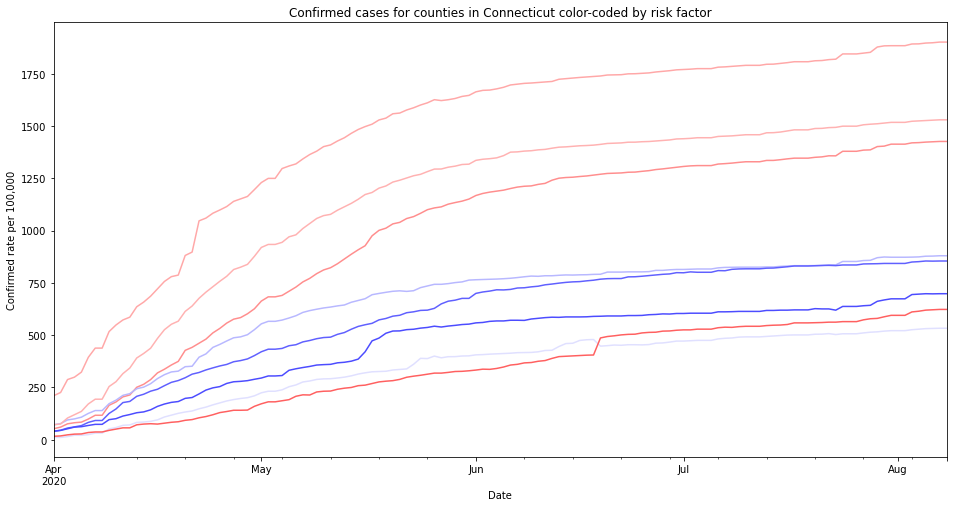

In [20]:
ax = df_date.plot(figsize=(16, 8), color=col_map, legend=False, title=f'Confirmed cases for counties in {state} color-coded by risk factor');
ax.set_xlabel("Date");
ax.set_ylabel("Confirmed rate per 100,000");

### Case counts by county color-coded by risk factor

In [21]:
# dimensions for subplot layout
cols = 5
rows = math.ceil(df_date.shape[0]/cols)

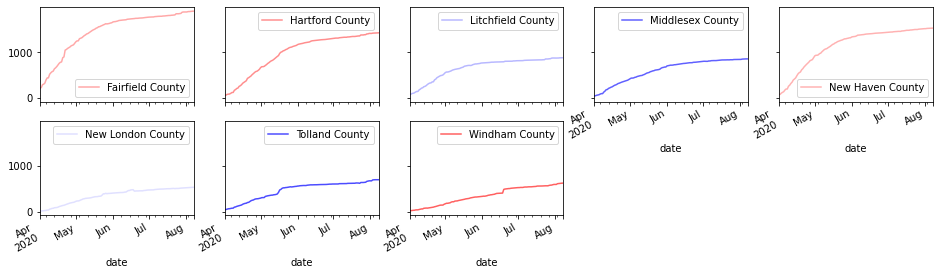

In [22]:
ax = df_date.plot(subplots=True, layout=(rows,cols), sharey=True, figsize=(16, 60), color=col_map);